In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.multitest as smm

from sklearn.metrics import auc

# Extract release rates and estimate metabolite values for E. coli batch cultures in galactose, L-malate and L-alanine
This notebook processes the batch culture and exometabolomics data from E. coli batch cultures in M9 media with galactose, L-malate or L-alanine as the only carbon source. Then, an E. coli GEM is used to predict metabolite values for E. coli in the same conditions. 

The output from this notebook is a spreadsheet with all rates and values.



## Define pathnames

In [3]:
folder = Path('../../../data/this_project/1_e_coli_batch_cultures/')
div_folder = Path('../../../data/this_project/5_div/')
supp_figure_folder = Path('../../../SupplementalFigures')


In [4]:
exometfn_A = folder / '1A_absolute_exometabolome_lcms.csv'
exometfn_B = folder / '1B_relative_exometabolome_z_scores_long.csv'
mapping_fn = div_folder / '5A_metabolomics_name_to_bigg.csv'
od_fn = folder / '1H_OD_and_gDW.csv'
gcms_fn = folder / '1E_gcms_umol.csv'

## Read mapping between names used in metabolomics results and BiGG IDs

In [5]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

## Define mapping between bioreactors and carbon source

In [6]:
rel_to_cs = {
    'REL01': 'Galactose',
    'REL02': 'Galactose',
    'REL03': 'Galactose',
    'REL04': 'L-malate',
    'REL05': 'L-malate',
    'REL06': 'L-malate',
    'REL07': 'L-alanine',
    'REL08':  'L-alanine',
    'REL09':  'L-alanine'
    }


## Read spreadsheet with OD and estimated gDW data

In [7]:
od_dfL = pd.read_csv(od_fn, index_col=0)

In [8]:
od_dfL.columns

Index(['Hours', 'Bioreactor', 'OD', 'Carbon source', 'Biomass [gDW/L]'], dtype='object')

### Plot gDW time series

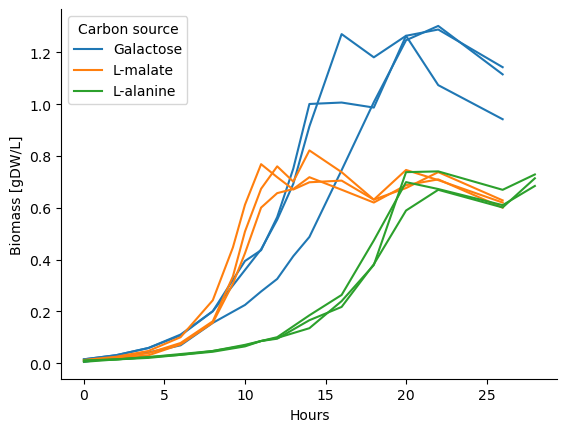

In [9]:
sns.lineplot(data = od_dfL, x = 'Hours', y = 'Biomass [gDW/L]', hue = 'Carbon source', estimator=None, units = 'Bioreactor')
sns.despine()

### Define dict with gDW/OD values
These values are estimated from the file 1G_measured_gDW.cs and used to estimate the gDW values in the OD spreadsheet


In [10]:
gDW_per_OD = {
    'Galactose': 0.346, #+- 0.016 gDW/L/OD,
    'L-malate':  0.279, #+- 0.017 gDW/L/OD,
    'L-alanine': 0.296  #+- 0.011 gDW/L/OD
}

## Calculate integrated biomass for each timepoint
Same as area under the curve (AUC). I'm using the auc function from sklearn, but scipy.integrate.simpson gives same results.

In [11]:
data = []
for rel in rel_to_cs.keys():
    df_rel = od_dfL.loc[od_dfL.Bioreactor == rel].copy()
    df_rel.sort_values(by = 'Hours', inplace=True)
    hours = df_rel.Hours.unique()
    for h in hours:
        hidx = df_rel.Hours <= h
        y_biomass = df_rel.loc[hidx, 'Biomass [gDW/L]']
        x_hours = df_rel.loc[hidx, 'Hours']
        if len(x_hours)>1:
            auc_val = auc(x_hours, y_biomass)
            data.append([rel, h, auc_val])
df_auc = pd.DataFrame(data, columns=['Bioreactor', 'Hours', 'AUC [gDW*h/L]'])

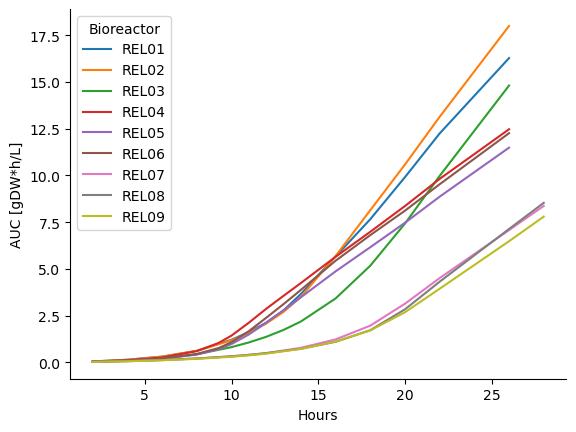

In [12]:
sns.lineplot(data = df_auc, x = 'Hours', y = 'AUC [gDW*h/L]', hue = 'Bioreactor')
sns.despine()

## Read LC-MS data that is quantified to absolute values

In [13]:
df_lcms = pd.read_csv(exometfn_A, index_col=0)

In [14]:
data_columns = sorted(df_lcms.columns[4:-3])

df_lcms.replace('ND', np.nan, inplace=True)
df_lcms[data_columns] = df_lcms[data_columns].astype(float)


### Remove errors and outliers in exometabolome data
For a few samples we observed a carry-over effect for malate (and for one sample succinate), i.e. after injection of samples with high malate concentration in a few cases the subsequent sample was clearly too high compared to the other timepoints and replicates. These samples were removed.

In [15]:
malate_errors = ['SM_MPTA_112023_55_Galactose-T12_M1_4',
                 'SM_MPTA_112023_M9_L-alanine_003_39',
                 'SM_MPTA_112023_88_L-alanine-T18_M9_31',
                 'SM_MPTA_112023_39_Galactose-T8_M3_3',
                 'SM_MPTA_112023_90_L-alanine-T18_M11_33',
                 'SM_MPTA_112023_65_Galactose-T14_M2_8']

for sample_id in malate_errors:
    idx = df_lcms['Sample_id']==sample_id
    df_lcms.loc[idx, 'Malate'] = np.nan        

succinate_errors = ['SM_MPTA_112023_M9_L-alanine_003_39']
for sample_id in succinate_errors:
    idx = df_lcms['Sample_id']==sample_id
    df_lcms.loc[idx, 'Succinate'] = np.nan        


## Read GC-MS


In [16]:
df_gcms = pd.read_csv(gcms_fn, index_col=0)

In [17]:
# Pyruvate is measured both with LC-MS and GC-MS
df_gcms.rename(columns={'Pyruvate': 'Pyruvate (gc-ms)'}, inplace = True)

## Add auc gDW data to dataframes

In [18]:
df1 = df_lcms.merge(df_auc, left_on=('Bioreactor', 'Hours'), right_on=('Bioreactor', 'Hours'), how = 'left')
df2 = df_gcms.merge(df_auc, left_on=('Bioreactor', 'Hours'), right_on=('Bioreactor', 'Hours'), how = 'left')

# Make long tables and concatenate


In [19]:
# df_lcms.loc[df_lcms.Timepoint.isin([1,2,3])].iloc[:, 4:-3].notna().sum()

In [20]:
id_vars_lcms = ['Sample_id', 'Carbon source', 'Hours', 'AUC [gDW*h/L]', 'Bioreactor', 'Timepoint']
dfl_lcms = df1.melt(id_vars=id_vars_lcms, value_vars=data_columns, value_name='Concentration [uM]', var_name = 'Metabolite')

In [21]:
id_vars_gcms = ['Sample_id', 'Carbon source', 'Hours', 'AUC [gDW*h/L]', 'Bioreactor', 'Timepoint']
dfl_gcms = df2.melt(id_vars=id_vars_gcms, value_vars= ['Acetate', 'Formate', 'Propanoate', 'Pyruvate (gc-ms)'], value_name='Concentration [uM]', var_name = 'Metabolite')

In [22]:
dfl = pd.concat([dfl_lcms, dfl_gcms])

In [23]:
dfl.loc[dfl['AUC [gDW*h/L]'].isna(), 'AUC [gDW*h/L]'] = 0

In [24]:
dfl.reset_index(inplace=True, drop=True)

# Read in relative quantification data
And add it to make one dataframe with all the information


In [25]:
dfz_lcms = pd.read_csv(exometfn_B, index_col=0)

In [26]:
dfz_lcms['Concentration [uM]'] = np.nan
additional_rows = []
for i, row in dfl.iterrows():
    idx = (dfz_lcms.Metabolite==row.Metabolite)&(dfz_lcms.Sample_id==row.Sample_id)
          # (dfz_lcms.Timepoint==row.Timepoint)&
    if idx.sum()==1:
        dfz_lcms.loc[idx, 'Concentration [uM]']=row['Concentration [uM]']
        
    elif idx.sum()==0:
        # print(row['Metabolite'])
        # Citrate, acetate, formate, propionate are not in the dfz_lcms data
        additional_rows.append(i)


In [27]:
df_to_add = dfl.loc[additional_rows].copy()
df_to_add['Z-score'] = np.nan

In [28]:
full_df = pd.concat([dfz_lcms, df_to_add])

## Use mean of LC-MS data and GC-MS for pyruvate
For L-malate condition. For L-alanine and Galactose condition the discrepancy between the two measurement methods are too different (~1-2 orders of magnitude), so for these conditions we discard all Pyruvate measurements from the rate estimates. 

In [29]:
pyr_df_lcms = full_df.loc[full_df.Metabolite=='Pyruvate']
pyr_df_gcms = full_df.loc[full_df.Metabolite=='Pyruvate (gc-ms)']

In [30]:
pyr_df = pyr_df_lcms.merge(pyr_df_gcms[['Timepoint','Bioreactor', 'Concentration [uM]']], left_on=('Bioreactor', 'Timepoint'), 
                  right_on = ('Bioreactor', 'Timepoint'))
pyr_df['Concentration [uM]'] = pyr_df.loc[:, ['Concentration [uM]_x', 'Concentration [uM]_y']].mean(axis=1)
pyr_df.loc[(pyr_df['Carbon source']!= 'L-malate'), 'Concentration [uM]'] = np.nan
pyr_df.drop(columns=['Concentration [uM]_x', 'Concentration [uM]_y'], inplace=True)

# sns.relplot(pyr_df, x = 'AUC [gDW*h/L]', y = 'Concentration [uM]', hue = 'Carbon source')

In [31]:
# Replace the lcms and gcms measurements with the joined data in the full data frame
full_df = full_df.loc[~full_df.Metabolite.isin(['Pyruvate', 'Pyruvate (gc-ms)'])]

In [32]:
full_df = pd.concat([full_df, pyr_df])

## Export data


In [33]:
export_cols = ['Sample_id', 'Carbon source', 'Metabolite', 'Concentration [uM]',
               'Hours', 'Bioreactor', 'AUC [gDW*h/L]', 'Z-score', 'Timepoint']
# Export long format csv file with concentrations
full_df[export_cols].to_csv(folder / '1ABE_merged_metabolomics_data.csv')

# Export AUC gDW
auc_fn = folder / '1F_auc_gDW.csv'
df_auc.to_csv(auc_fn)

# Improve data quality by joining different sources of information

## Use data quantified to absolute values to create standard curves to fill in missing concentration values
For the following metabolites there are samples which are quantified to relative quantities but not to absolute values using the labelled standards (number of samples in parenthesis):
- __Phenylalanine__ (5)
- __Proline__ (7)
- __Creatine__ (6)
- Alpha-aminoadipate (4)
- Glutamine (19)
- _Serine_ (18)
- _Lysine_ (9)
- _Lactate_ (7)
- NAD (7)
- Isocitrate (8)

For the metabolites in bold one can leverage the samples both quantified to absolute concentration and to z-scores to get reasonable standard curves (R^2 > 0.7) that we can levereage to fill in missing non-negative absolute values. 

For the ones in italic we can estimate good standard curves, but we using these standard curves leads to negative values (concentrations). Thus, for these metabolites we 

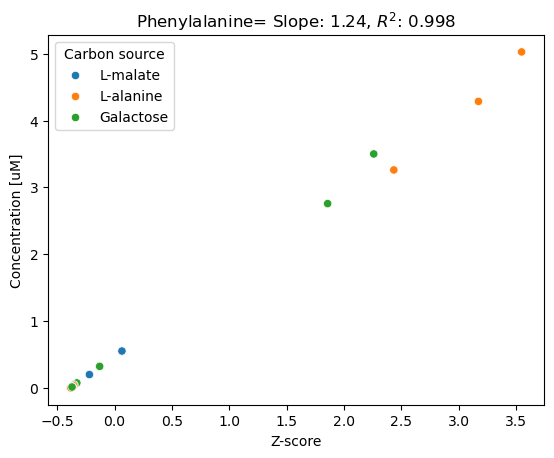

4145    0.000751
4149    0.000113
4151   -0.002563
4161   -0.000362
4162    0.001290
4184    0.001811
Name: Concentration [uM], dtype: float64


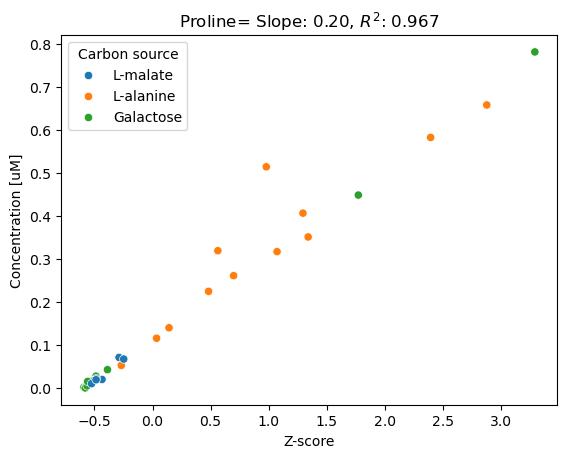

4233    0.004375
4235    0.001771
4239   -0.001854
4241   -0.010996
4248    0.003506
4249    0.003416
4252   -0.002082
4257    0.007108
4258    0.005204
4259    0.009141
4262    0.009127
4269    0.000935
Name: Concentration [uM], dtype: float64


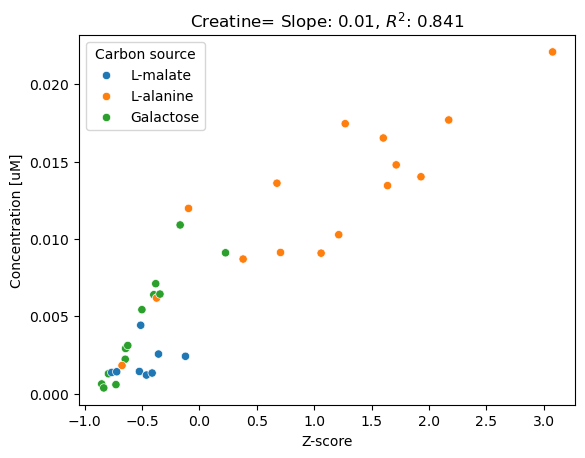

1314    0.002721
1323    0.002881
1326    0.002840
1327    0.001320
1332    0.002388
1334    0.003139
1337    0.003227
1339    0.001874
Name: Concentration [uM], dtype: float64


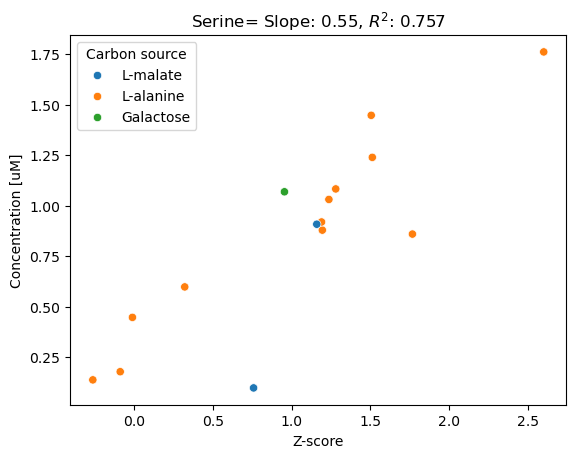

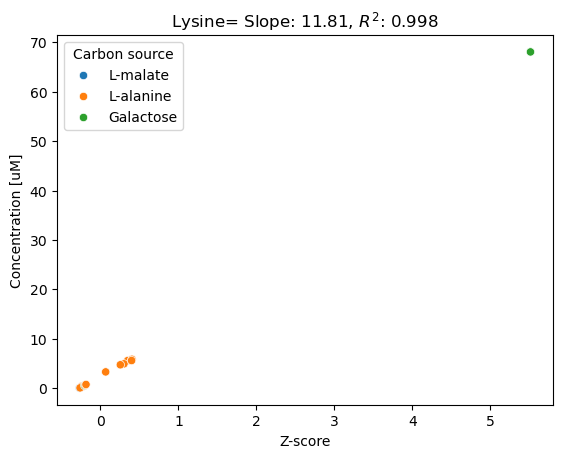

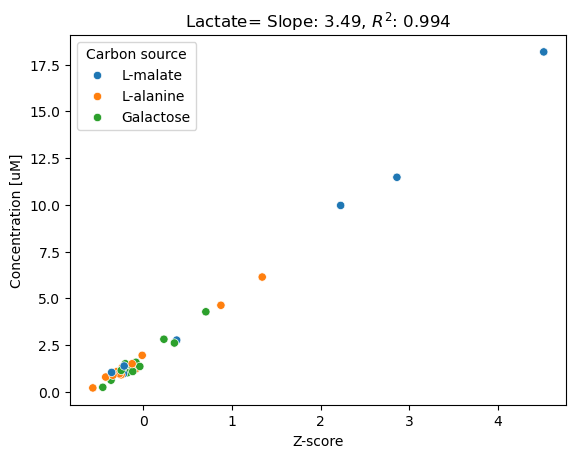

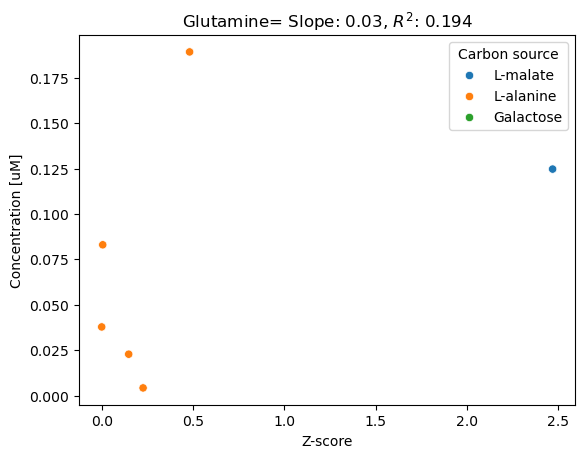

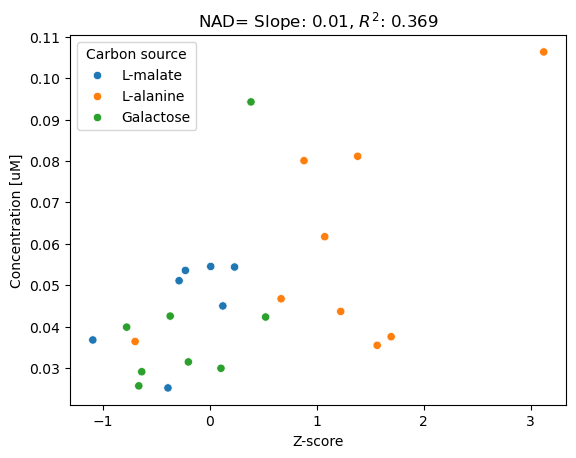

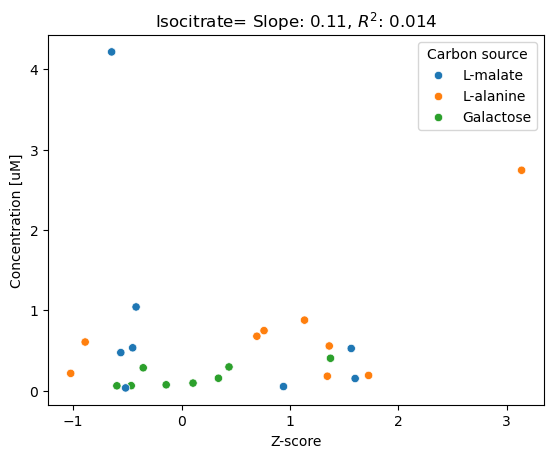

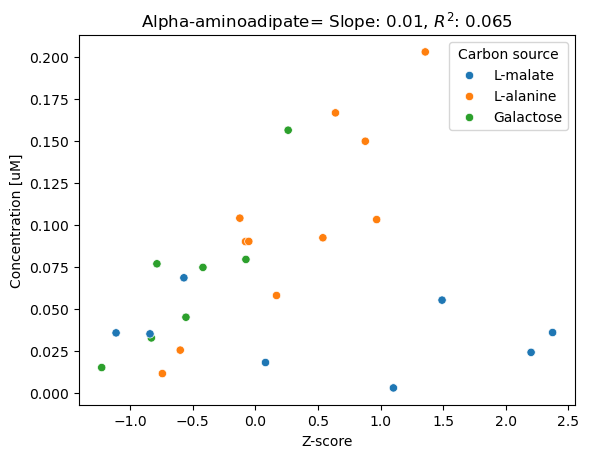

In [34]:
standard_curve_metabolites = [
    'Phenylalanine',#: ['Galactose', 'L-malate', 'L-alanine'],
    'Proline',#: ['Galactose', 'L-malate', 'L-alanine'],
    'Creatine',
    'Serine',
    'Lysine',
    'Lactate',
    'Glutamine',
    'NAD',
    'Isocitrate',
    'Alpha-aminoadipate']

metabolites_to_fill = ['Phenylalanine', 'Proline', 'Creatine']
plot = True
filled_df = full_df.copy()
standard_curve_dict = {}
for met in standard_curve_metabolites:
    dfi = full_df.loc[full_df.Metabolite==met]
    notnan = dfi['Concentration [uM]'].notna()&dfi['Z-score'].notna()
    y_values = dfi.loc[notnan,'Concentration [uM]']
    x_values = dfi.loc[notnan, 'Z-score']
    res = st.linregress(x_values, y_values)

    # Plot
    if plot:
        ax = sns.scatterplot(dfi, y = 'Concentration [uM]', x = 'Z-score', hue = 'Carbon source')
        # print(f'{res.slope:.2f}, {res.rvalue**2:.3f}, {res.pvalue:.2e}')
        ax.set_title(f'{met}= Slope: {res.slope:.2f}, $R^2$: {res.rvalue**2:.3f}')
        plt.show()
    standard_curve = lambda x: res.intercept + res.slope*x
    standard_curve_dict[met] = standard_curve
    # Fill in missing values
    if met in metabolites_to_fill:
        fill_idx = (full_df.Metabolite==met)&full_df['Concentration [uM]'].isna()&full_df['Z-score'].notna()
        filled_df.loc[fill_idx, 'Concentration [uM]'] = full_df.loc[fill_idx, 'Z-score'].map(standard_curve)
        print(filled_df.loc[fill_idx, 'Concentration [uM]'])

## Estimate rate per metabolite per carbon source
Primarily use absolute quantification data

In [35]:
abs_rate_mets = ['Acetate',
                 'Alanine',
                 'Alpha-aminoadipate',
                 'Alpha-aminobutyrate',
                 'Asparagine',
                 'Aspartate',
                 'Beta-alanine',
                 'Cis-aconitate',
                 'Citrate',
                 'Creatine',
                 'Deoxycarnitine (deoxy-c0)',
                 'Formate',
                 'Gamma-aminobutyrate',
                 'Glutamate',
                 'Glutamine',
                 'Glutarate',
                 'Glutarylcarnitine (c5-dc)',
                 'Glycine',
                 'Hexoses',
                 'Isocitrate',
                 'Isoleucine',
                 'Lactate',
                 'Leucine',
                 'Lysine',
                 'Malate',
                 'Methionine',
                 'NAD',
                 'Phenylalanine',
                 'Pipecolic acid',
                 'Proline',
                 'Propanoate',
                 'Pyruvate',
                 'Sebacoyl-l-carnitine (c10-dc)',
                 'Serine',
                 'Succinate',
                 'Trans-aconitate',
                 'Tyrosine',
                 'Valine']

abs_rate_poor_mets = {'Glutamine': ['Galactose', 'L-malate', 'L-alanine'],
                     'Alpha-aminoadipate':['L-alanine'],
                     'Serine':['Galactose', 'L-malate'],
                     'Lysine': ['Galactose', 'L-malate'],
                     'Lactate': ['L-malate'],
                     'NAD': ['Galactose', 'L-malate', 'L-alanine'],
                     'Isocitrate': ['Galactose']}

skip_t0 = {'L-malate':['Arginine', 'Aspartate', 'Citrulline', 'Glutamate', 
                       'Isovalerylcarnitine (c5/ic5)', 'Methylglutarate', 'Nicotinamide','Phenylacetaldehyde', 
                       'Phenylalanine', 'Proline', 'Isoleucine', 'Lactate'],
'Galactose': ['Isovalerylcarnitine (c5/ic5)', 'Lactate', 'O-acetylserine', 'Ophtalmate', 'Phenylacetaldehyde', 'Proline', 'Threonine', '1,3-diaminopropane'],
'L-alanine': ['Lactate', 'Valine', 'NAD']}

In [36]:
filled_df.Timepoint = filled_df.Timepoint.astype(int)

/Users/snorre/miniconda3/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too smal

378


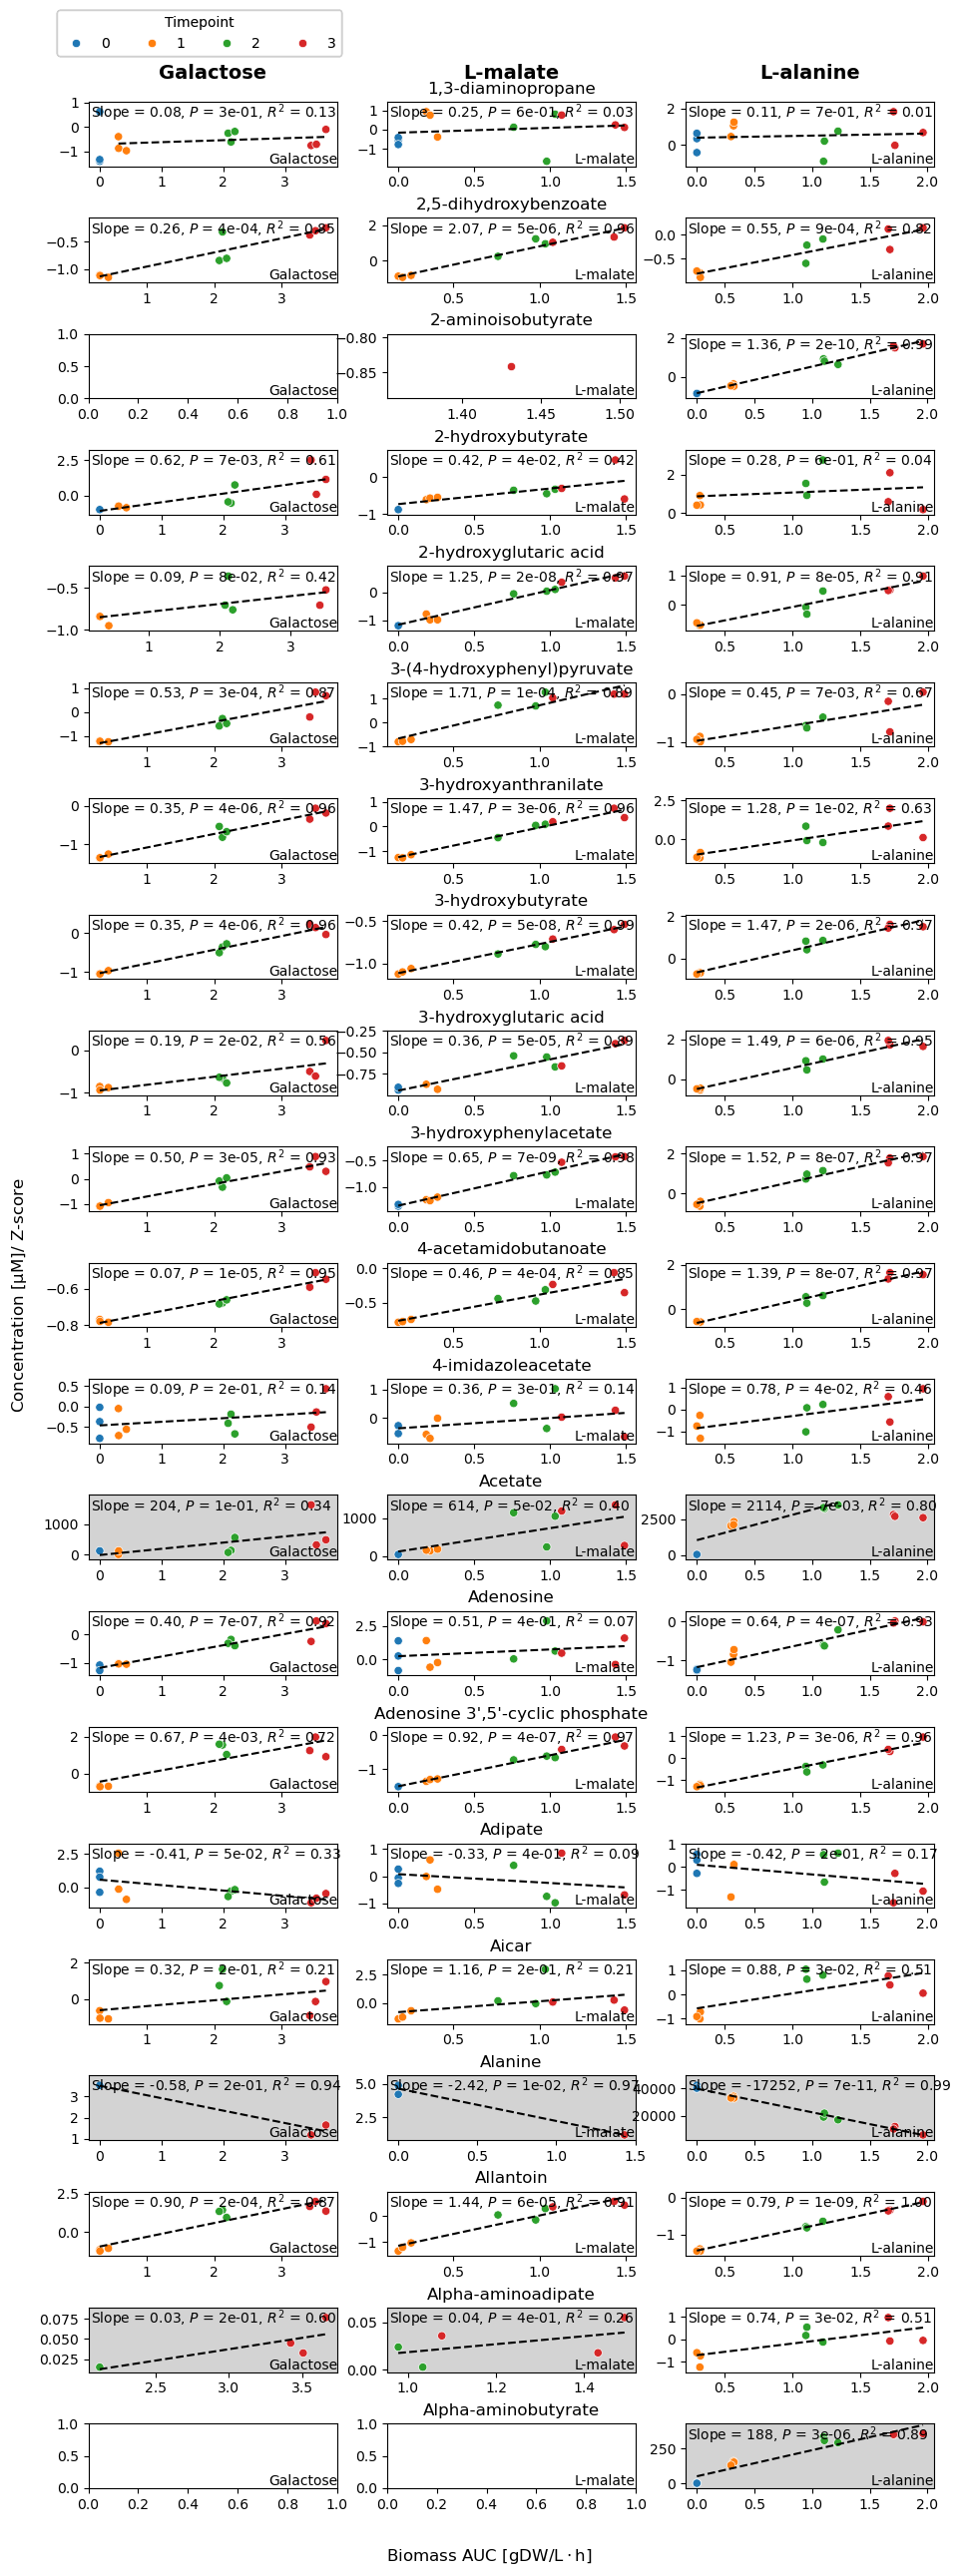

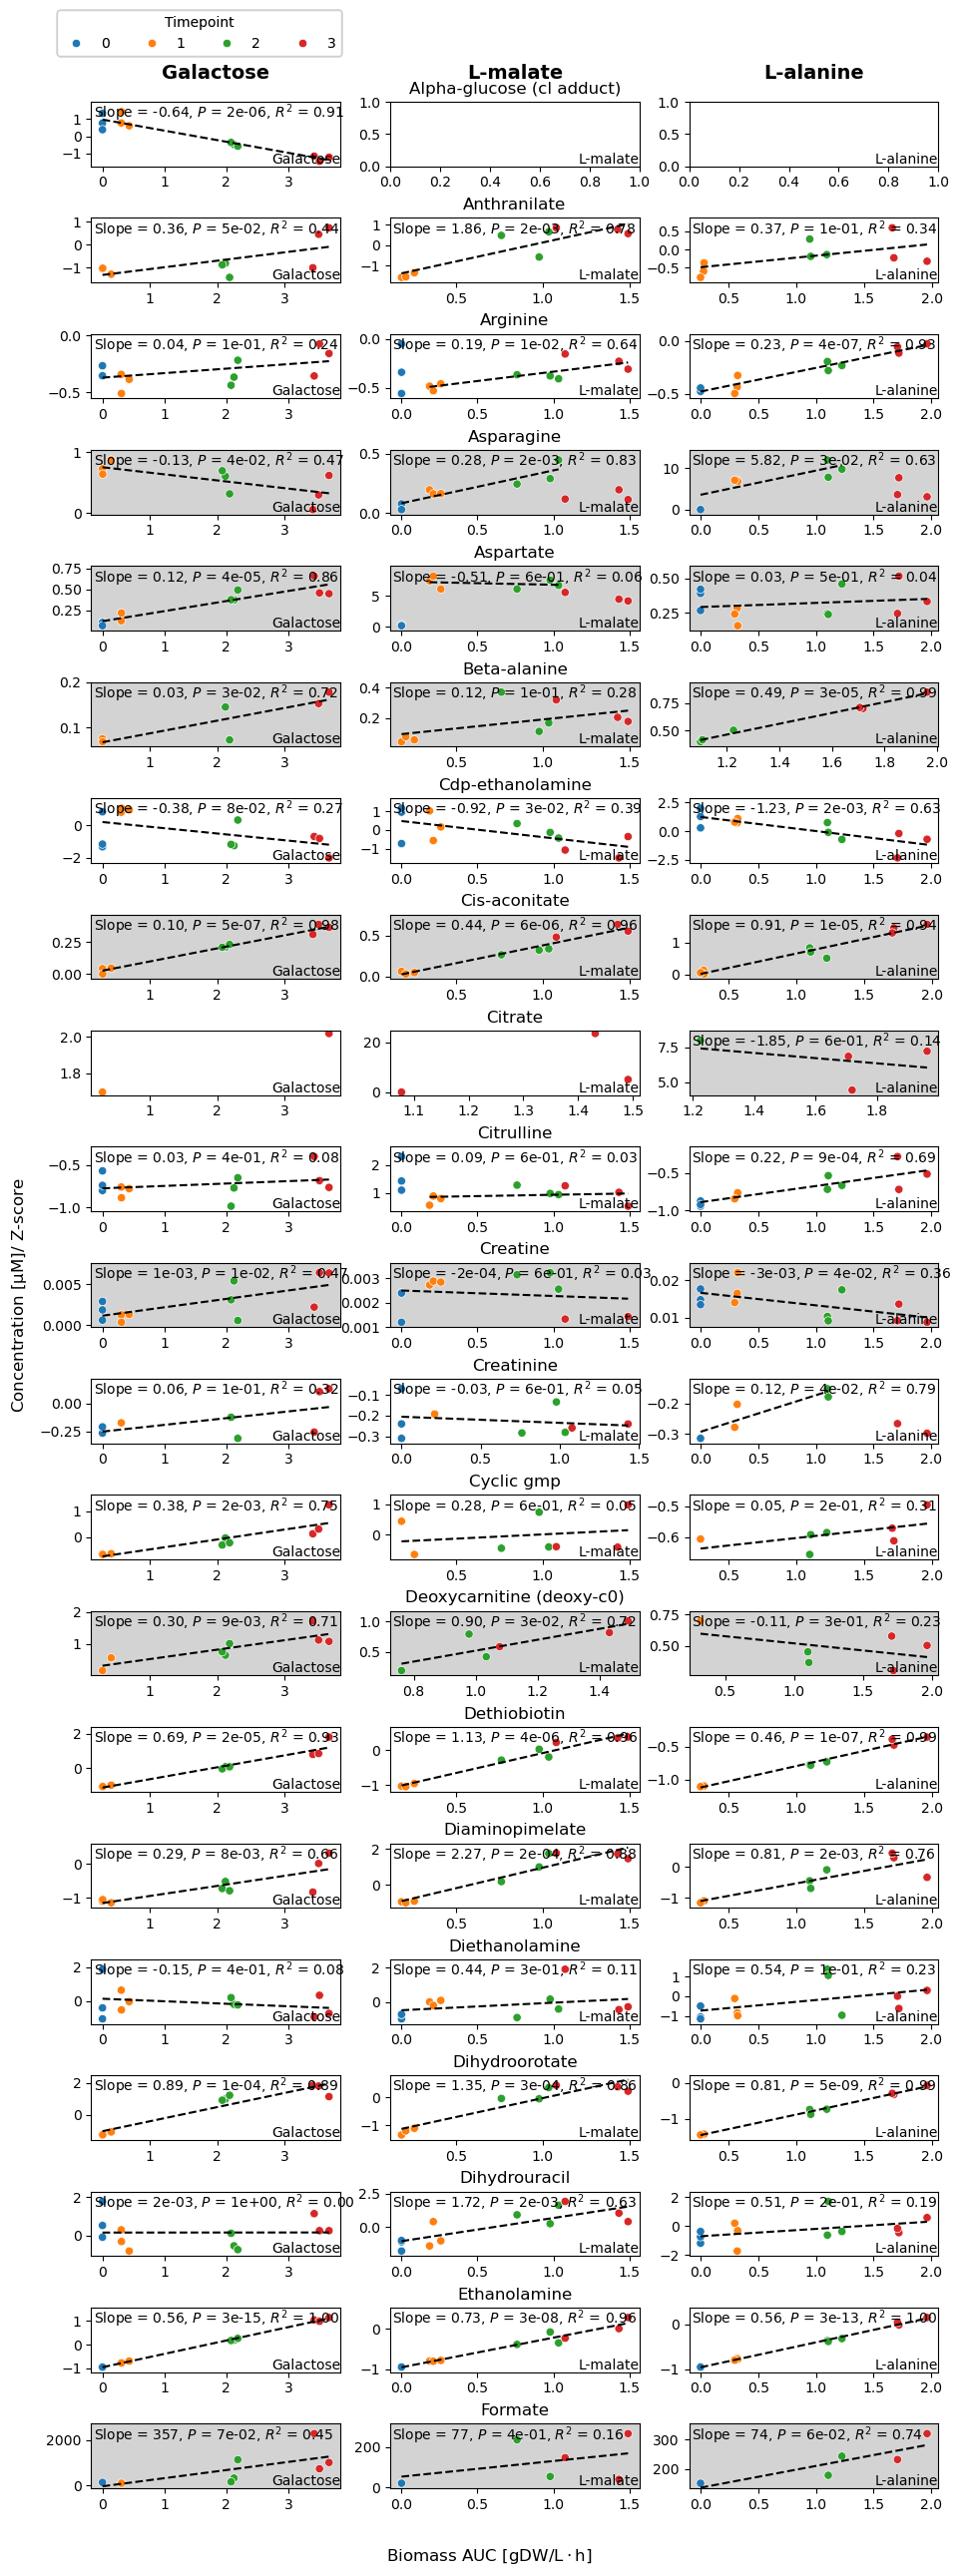

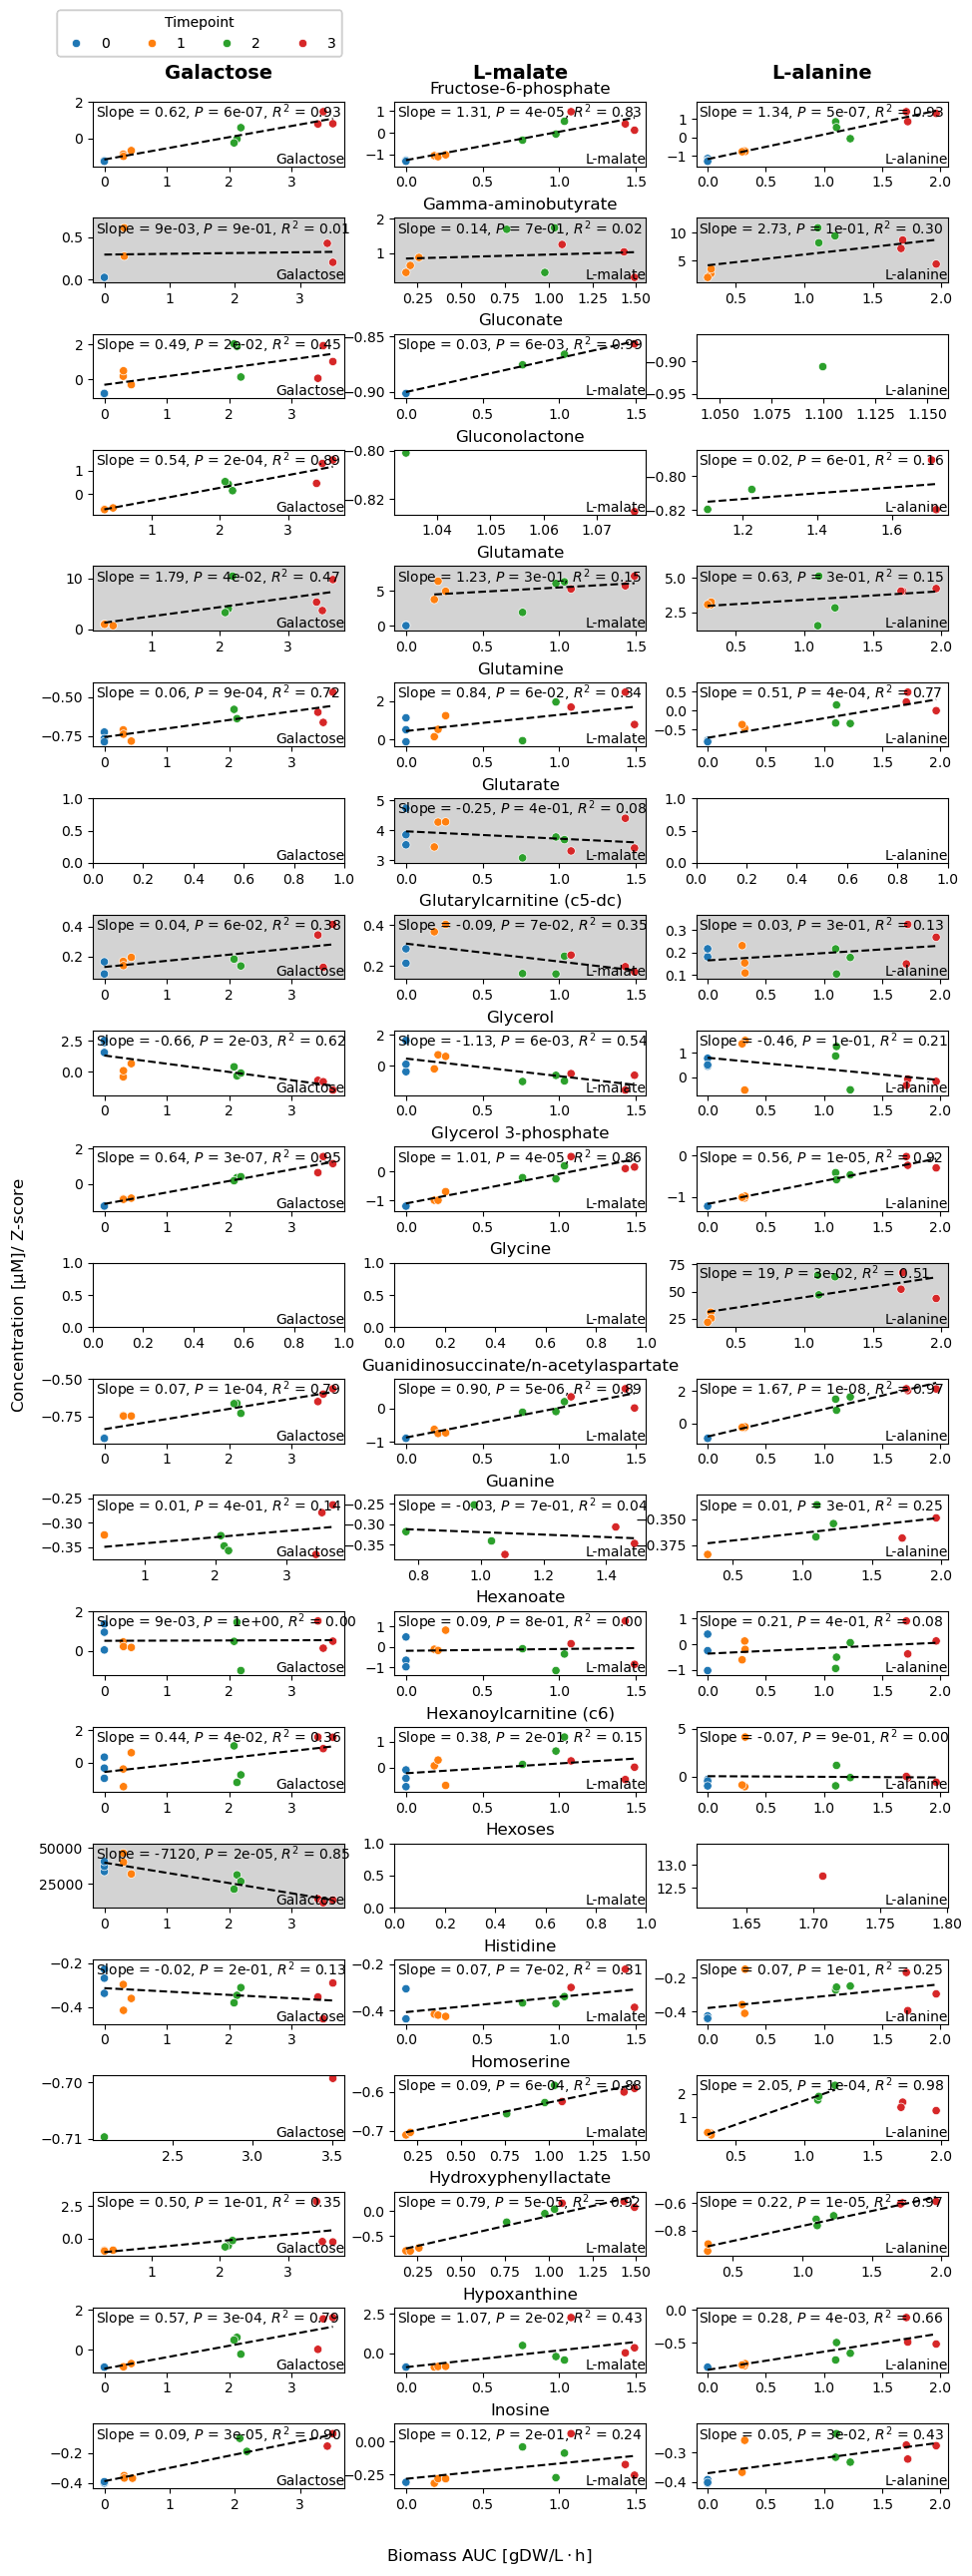

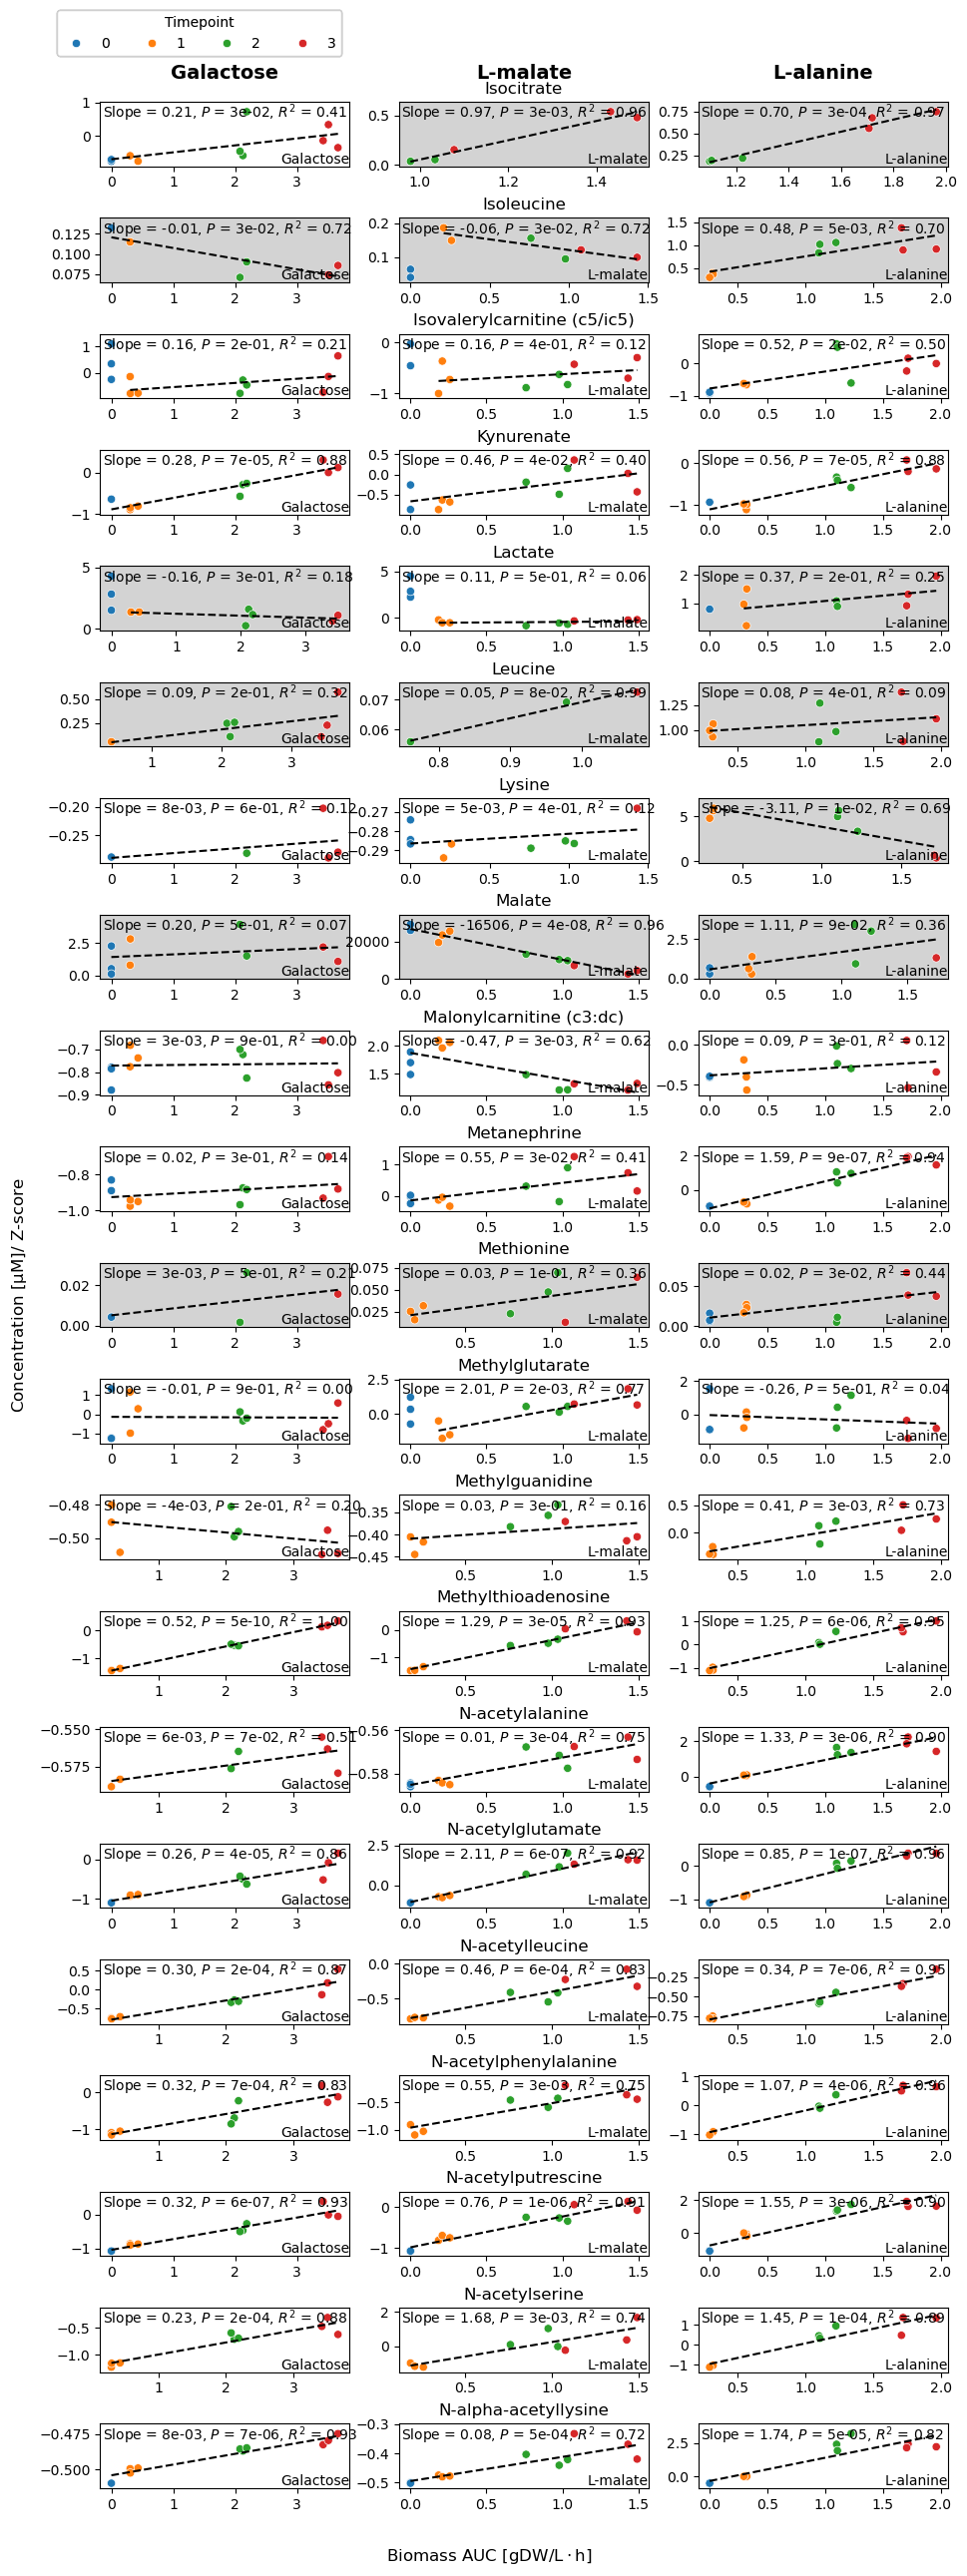

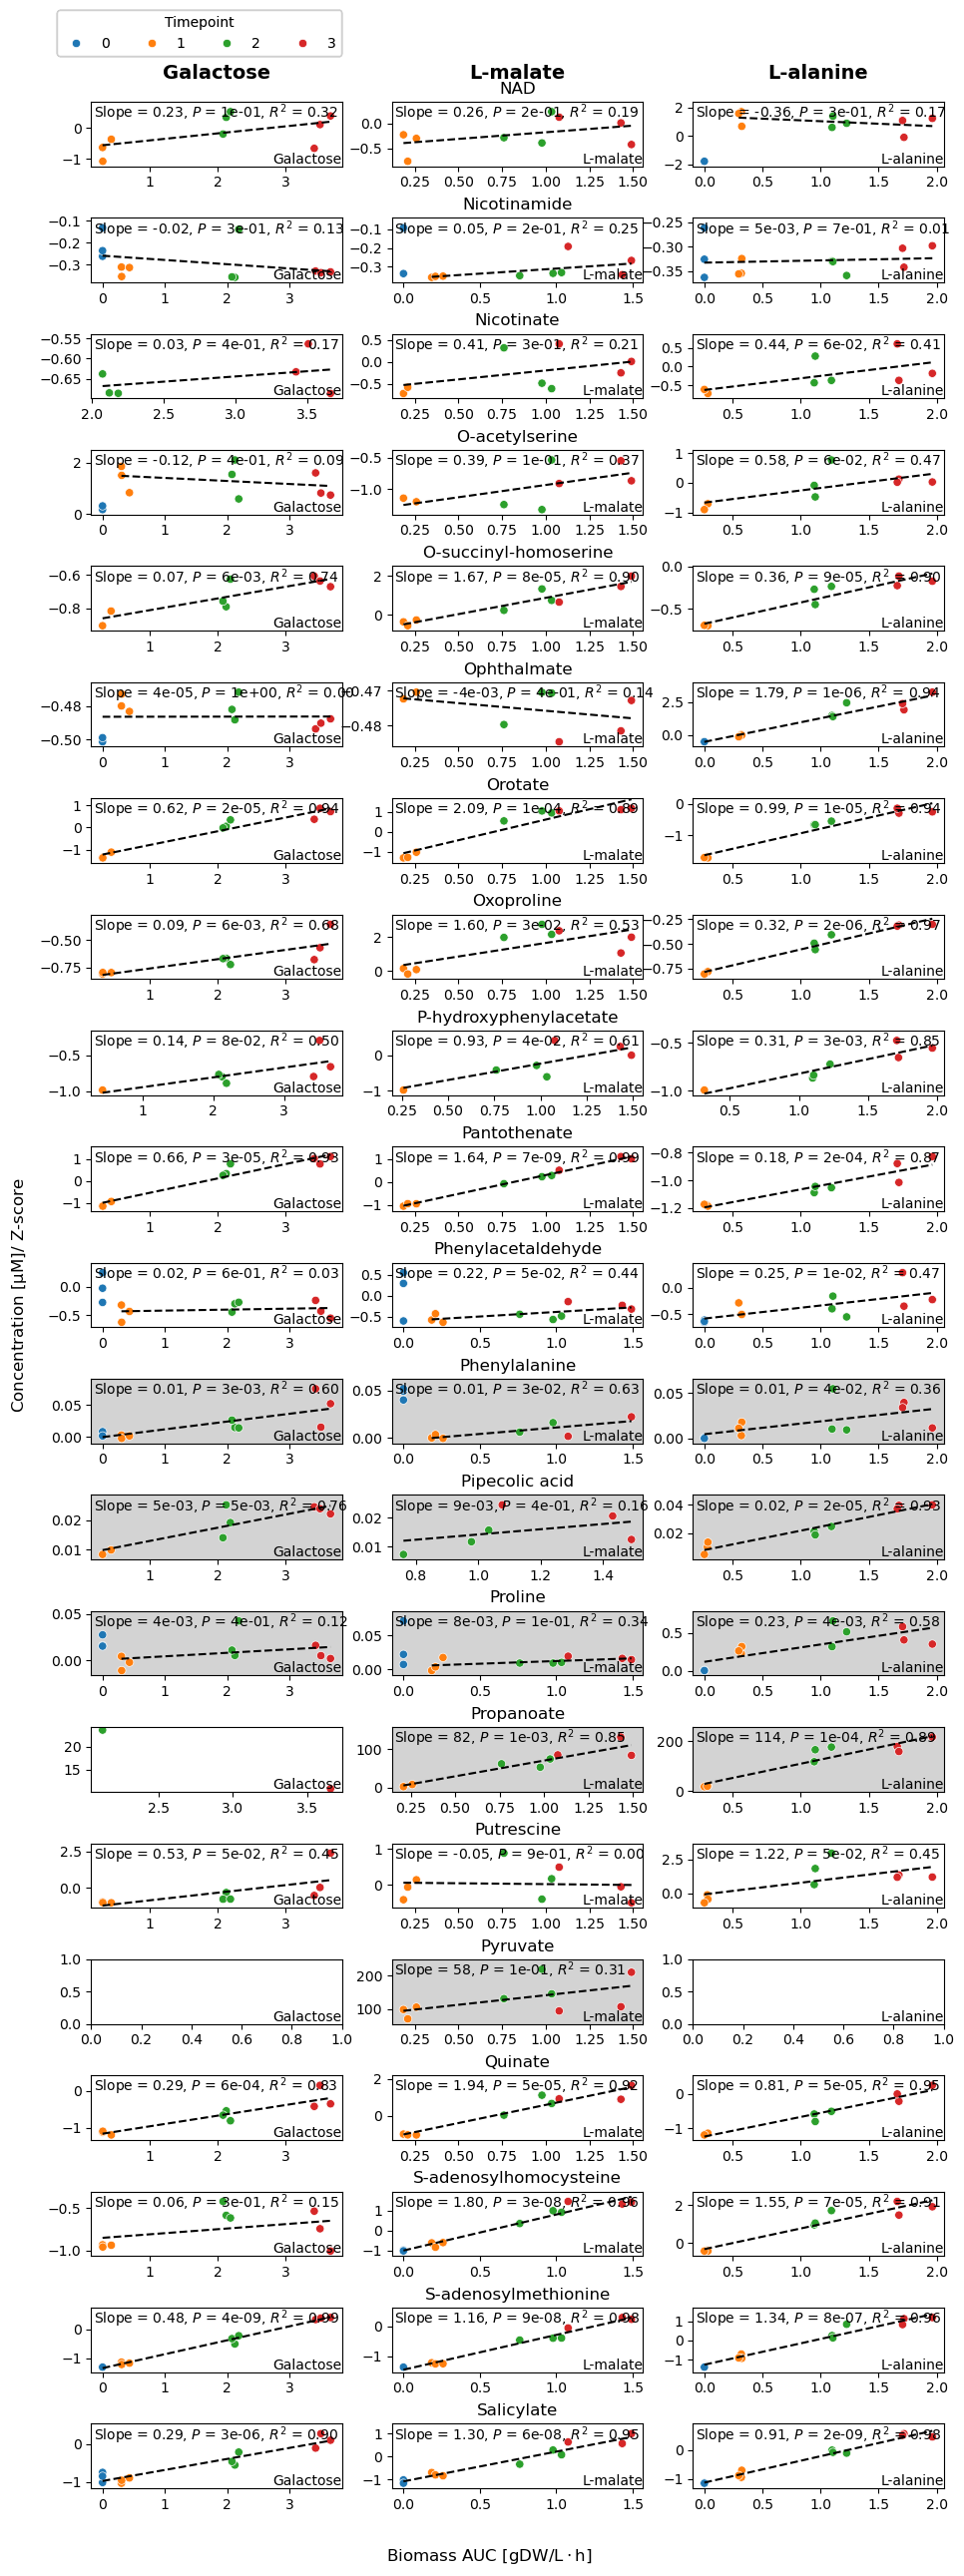

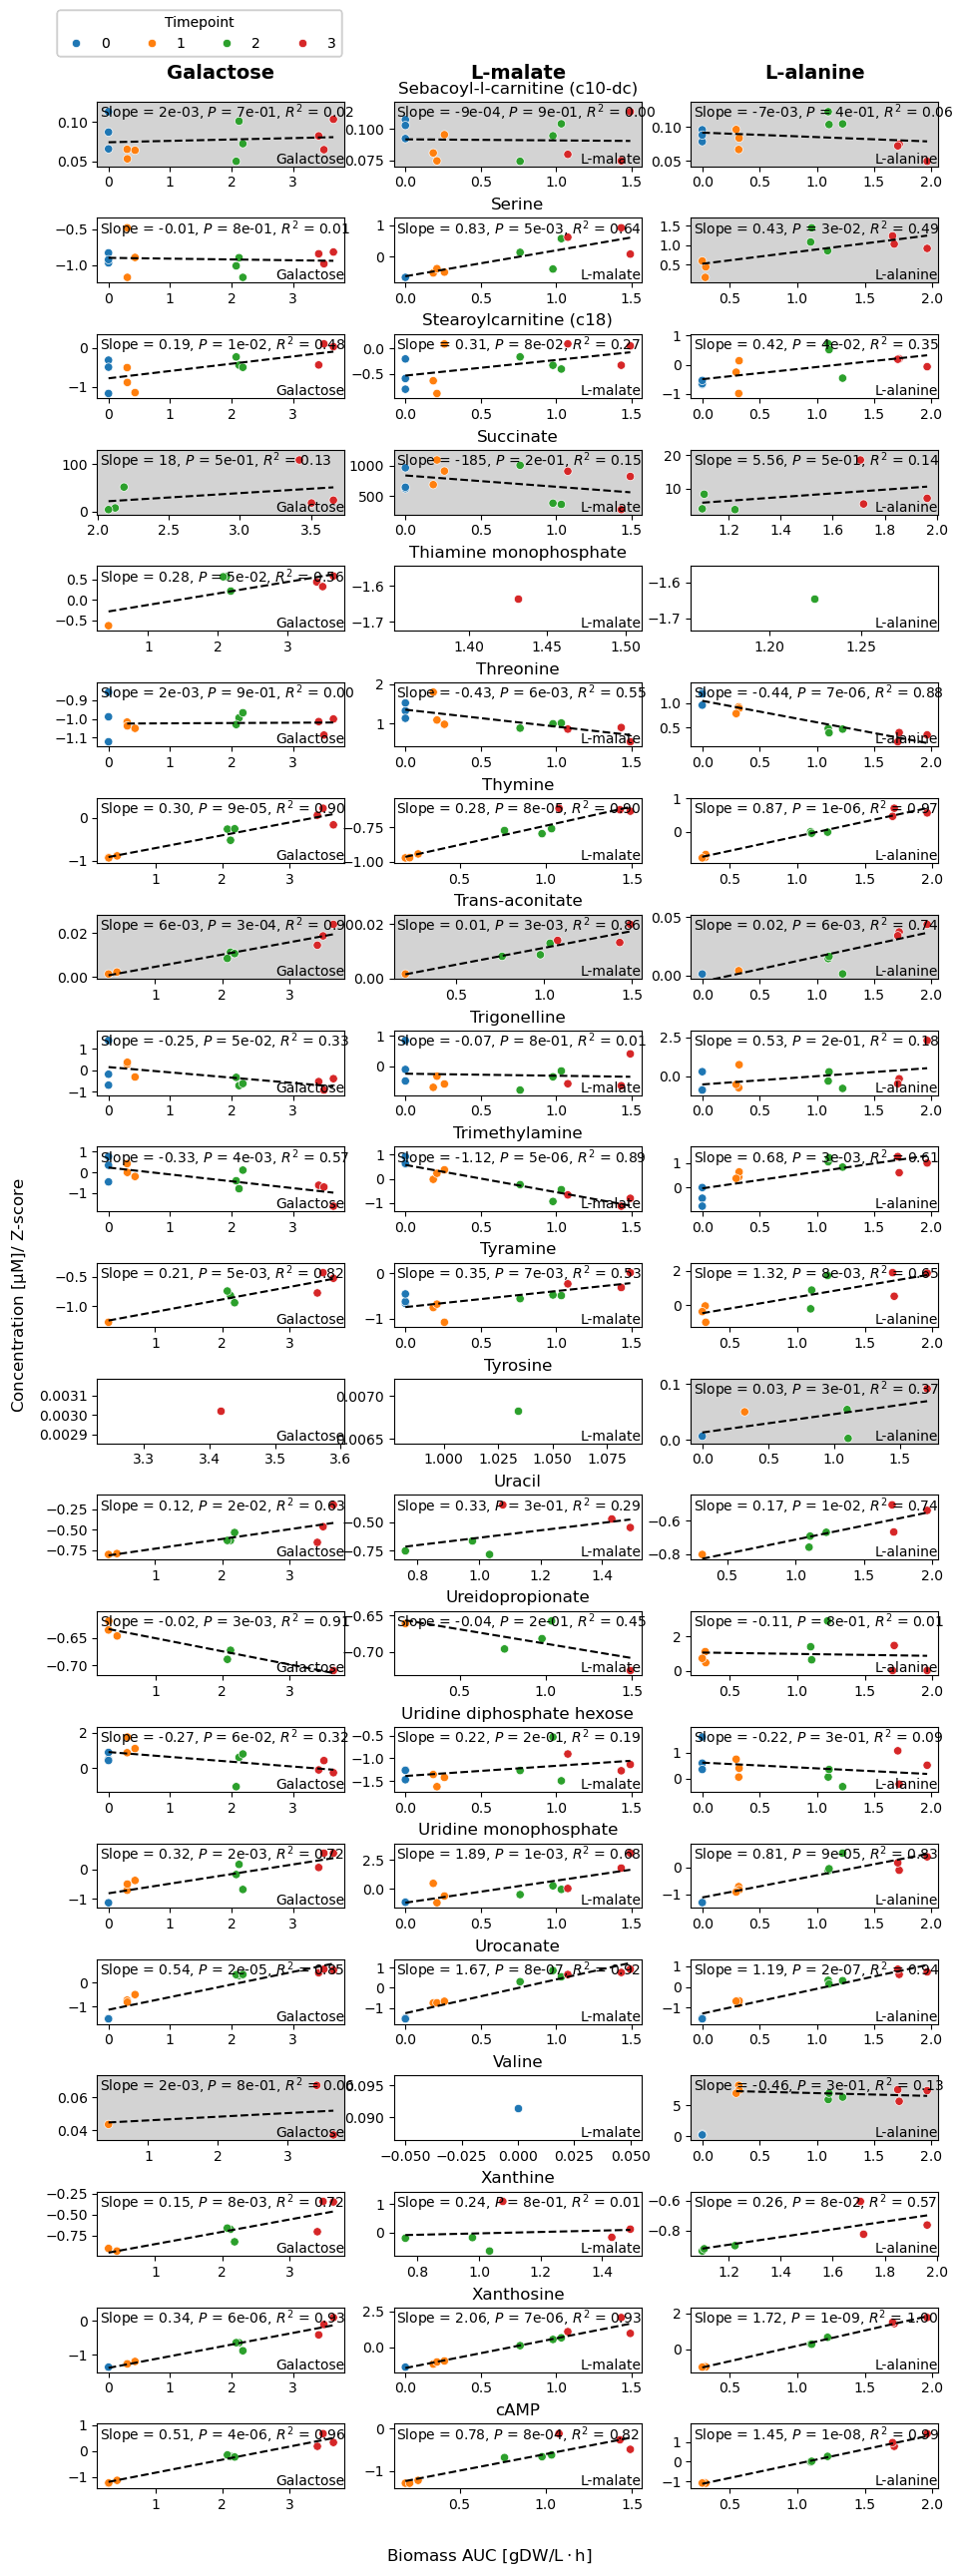

In [37]:
ttest_t2t3_pval_threshold = 0.05
i = 0
plot = True
data = []
carbon_sources = ['Galactose', 'L-malate', 'L-alanine']
metabolites = sorted(filled_df.Metabolite.unique())
if plot:
    fig1, axes1 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.9})
    fig2, axes2 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.98})
    fig3, axes3 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.98})
    fig4, axes4 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.98})
    fig5, axes5 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.98})
    fig6, axes6 = plt.subplots(21,3, figsize = (10,26))#, layout = 'constrained', gridspec_kw = {'top': 0.98})
    # fig, axes = plt.subplots(126,3, figsize = (10,200))
    figures = [fig1, fig2, fig3, fig4, fig5, fig6]
    axes = np.concat([axes1.flatten(), axes2.flatten(), 
                      axes3.flatten(), axes4.flatten(), axes5.flatten(),
                      axes6.flatten()])
for met in metabolites:
    for cs in carbon_sources:
        k = i%(21*3)
        if plot:
            ax = axes[i]
        idx = (filled_df.Metabolite==met)&(filled_df['Carbon source']==cs)&(filled_df.Timepoint<4)
        dfi = filled_df.loc[idx]

        if met in skip_t0[cs]:
            timepoints = [1,2,3]
        else:
            timepoints = [0, 1,2,3]

        # Determine to fit slope on z-score or absolute concentrations
        if met in abs_rate_mets:
            try:
                cs_list = abs_rate_poor_mets[met]
            except:
                yaxis = 'Concentration [uM]'
            else:
                if cs in cs_list:
                    yaxis = 'Z-score'
                else:
                    yaxis = 'Concentration [uM]'
        else:
            yaxis = 'Z-score'
        

        t3_values = dfi.loc[(dfi.Timepoint==3), yaxis].values #&dfi['Z-score'].notna()
        t2_values = dfi.loc[(dfi.Timepoint==2), yaxis].values #&dfi['Z-score'].notna()
        
        if len(t2_values) and len(t3_values):
            ttest_t2t3 = st.ttest_ind(t2_values, t3_values, nan_policy='omit', alternative='greater')
            t3t2_pval = ttest_t2t3.pvalue
        else:
            t3t2_pval = np.nan

        if plot:
            if k == 0:
                legend = True
            else:
                legend = False
            #     # sns.scatterplot(dfi, x = 'AUC [gDW*h/L]', y = yaxis, ax = ax, hue = 'Timepoint',
            #     #                palette = 'tab10')
            # else:
            sns.scatterplot(dfi, x = 'AUC [gDW*h/L]', y = yaxis, ax = ax, hue = 'Timepoint',
                           palette = 'tab10', legend = legend)
            if k == 0:
                # sns.move_legend(ax, "lower left", ncols = 4, bbox_to_anchor=(0.0, 1.1), 
                #                frameon = True)
                handles, labels = ax.get_legend_handles_labels()
                for fig in figures:
                    fig.legend(handles=handles, labels=labels, ncols = 4, loc = 'lower left',
                                 bbox_to_anchor = (0.06, 0.975), title = 'Timepoint')
                ax.get_legend().remove()
            if k <3: #Top row
                ax.annotate(cs, (0.5, 1.35), size=14,
                           horizontalalignment='center', xycoords = 'axes fraction',
                           weight="semibold")
                # plt.figlegend(handles=[line1, line2])
        nanfilter = dfi[yaxis].notna()
        
        # Determine whether to include T3 in the fit (discard if the general slope
        # is positive, but T3 is significantly smaller than T2)
        if (nanfilter.sum()<3):
            slope_estimate = np.nan
        else:
            res_all = st.linregress(dfi.loc[nanfilter,'AUC [gDW*h/L]'], dfi.loc[nanfilter,yaxis])
            slope_estimate = res_all.slope
        
        if (slope_estimate > 0) and (t3t2_pval < ttest_t2t3_pval_threshold):
            timepoints.pop(-1)

        # Now fit
        idx_fit = dfi.Timepoint.isin(timepoints)&nanfilter
        
        x_values = dfi.loc[idx_fit,'AUC [gDW*h/L]'].values
        y_values = dfi.loc[idx_fit, yaxis].values        

        if (len(y_values)>=3) and (len(dfi.loc[idx_fit,'Timepoint'].unique()) > 1):
            slope, intercept, rvalue, pvalue, stderr = st.linregress(x_values, y_values)
            
            if plot:
                xarr = np.linspace(x_values.min(), x_values.max(), 10, endpoint=True)
                yfit = intercept + slope*xarr
                ax.plot(xarr, yfit, c = 'k', ls = '--')
        else:
            slope = intercept = rvalue = pvalue = stderr = np.nan
            yaxis = None
        # Store data
        data.append([cs, met, slope, intercept, rvalue, pvalue, stderr, len(y_values),t3t2_pval,yaxis])

        
        if plot:
            ax = axes[i]
            # ax.set(yticklabels=[], xticklabels=[])
            # ax.text(cs, xycoords = 'axes fraction')
            
            ax.set_ylabel(None)
            ax.set_xlabel(None)
            # ax.annotate(f'r: {res.slope:.1e}', (0.1, 0.9), xycoords = 'axes fraction')
            if np.isfinite(pvalue):
                spread = np.abs(np.max(dfi[yaxis])-np.min(dfi[yaxis]))
                y_max = np.max(dfi[yaxis]) + spread*0.2
                y_min = np.min(dfi[yaxis]) - spread*0.1
                ax.set_ylim(y_min, y_max)
                if (np.abs(slope)>1e-2)&(np.abs(slope)<10):
                    slope_label = f'Slope = {slope:.2f},'
                elif np.abs(slope)>10:
                    slope_label = f'Slope = {slope:.0f},'
                else:
                    slope_label = f'Slope = {slope:.0e},'
            
                ax.annotate(f'{slope_label} $P$ = {pvalue:.0e}, $R^2$ = {rvalue**2:.2f}', (0.01, 0.99), xycoords = 'axes fraction', va = 'top', ha = 'left')
                # ax.annotate(f'$R^2$ = {rvalue**2:.2f}', (0.75, 0.8), xycoords = 'axes fraction', va = 'top', ha = 'left')
            # ax.annotate(cs, (0.99, 0.01), xycoords = 'axes fraction', )
            ax.text(1, 0, cs,
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        transform=ax.transAxes)
            if cs == 'L-malate':
                ax.set_title(met)
            if (yaxis == 'Concentration [uM]') and slope:
                ax.set_facecolor('lightgray')
                ax.set_alpha(0.5)
            # ax.set_title(f'{cs}: {met}, {res.pvalue:.1e}, {res.slope:.3f}, {res.stderr:.3f}, [{res.slope - res.stderr:.3f},  {res.slope + res.stderr:.3f}]')
        i+= 1
print(i)

if plot:
    # plt.subplots_adjust(hspace=0.8)
    # plt.tight_layout()
    for i, fig in enumerate(figures):
        fig.supxlabel(r'Biomass AUC [$\rm{gDW/L \cdot h}$]', )
        fig.supylabel(r'Concentration [$\rm{\mu}$M]/ Z-score')
        fig.tight_layout()
        fig.subplots_adjust(top=0.96, hspace = 0.8,wspace = 0.2, bottom = 0.04)
        
        
        fig.savefig(supp_figure_folder / f'fitted_rates_SINTEF-23_{i}.pdf')
    plt.show()

In [37]:
df_rate = pd.DataFrame(data, columns = ['Carbon source', 
            'Metabolite', 'Slope', 'Intercept', 'r', 'p-value', 'Std. Err', 'N',
            'T3_pval', 'Fitted on'])


In [38]:
df_rate['Comment'] = ""
df_rate['Rate [mmol/gDW/h]'] = np.nan
df_rate['Std. Err [mmol/gDW/h]'] = np.nan
df_rate['Rate [1/gDW/h]'] = np.nan
df_rate['Std. Err [1/gDW/h]'] = np.nan
for i, row in df_rate.iterrows():
    if row['Fitted on'] == 'Z-score':
        df_rate.at[i, 'Rate [1/gDW/h]'] = row['Slope']
        df_rate.at[i, 'Std. Err [1/gDW/h]'] = row['Std. Err']
        
    elif row['Fitted on'] == 'Concentration [uM]':
        # df_rate.at[i, 'Slope unit'] = 'umol/(gDW*h)'
        df_rate.at[i, 'Rate [mmol/gDW/h]'] = row['Slope']*1e-3
        df_rate.at[i, 'Std. Err [mmol/gDW/h]'] = row['Std. Err']*1e-3
    else:
        df_rate.at[i, 'Comment'] = 'Not sufficient data'

    if row['Metabolite'] in metabolites_to_fill:
        df_rate.at[i, 'Comment'] = 'Some abs. conc. values calculated from standard curve'


In [39]:
abs_rate_poor_mets

{'Glutamine': ['Galactose', 'L-malate', 'L-alanine'],
 'Alpha-aminoadipate': ['L-alanine'],
 'Serine': ['Galactose', 'L-malate'],
 'Lysine': ['Galactose', 'L-malate'],
 'Lactate': ['L-malate'],
 'NAD': ['Galactose', 'L-malate', 'L-alanine'],
 'Isocitrate': ['Galactose']}

## Now scale the metabolites that are fitted on z-score data but where there is some information about the absolute concentrations

We assume that the paired data gives a reasonable estimate of the standard deviations of the relative and absolute data

In [40]:
for met, cs_list in abs_rate_poor_mets.items():
    for cs in cs_list:
        rate_idx = (df_rate.Metabolite==met)&(df_rate['Carbon source']==cs)
        
        full_df_idx = (full_df.Metabolite==met)&(full_df['Carbon source']==cs)&full_df['Z-score'].notna()&full_df['Concentration [uM]'].notna()
        x_data = full_df.loc[full_df_idx, 'AUC [gDW*h/L]']
        rel_data = full_df.loc[full_df_idx, 'Z-score']
        abs_data = full_df.loc[full_df_idx, 'Concentration [uM]']

        if df_rate.loc[rate_idx, 'Rate [mmol/gDW/h]'].isna().values[0]:
            scaling = abs_data.std()/rel_data.std()
            df_rate.loc[rate_idx, 'Rate [mmol/gDW/h]'] = df_rate.loc[rate_idx, 'Rate [1/gDW/h]']*scaling*1e-3
            df_rate.loc[rate_idx, 'Std. Err [mmol/gDW/h]'] = df_rate.loc[rate_idx, 'Std. Err [1/gDW/h]']*scaling*1e-3
            df_rate.loc[rate_idx, 'Comment'] = 'Rate scaled for slope estimated on Z-scores'

# Save rates

In [41]:
df_rate.to_csv(folder / '1J_metabolite_rates.csv')

In [42]:
len(df_rate.Metabolite.unique())

126

# Print out info about the fitted rates

   Carbon source Rate Classification  Count
0      Galactose   Insufficient data      9
1      Galactose      Negative slope      5
2      Galactose     Not Significant     57
3      Galactose      Positive slope     55
4      L-alanine   Insufficient data      6
5      L-alanine      Negative slope      4
6      L-alanine     Not Significant     46
7      L-alanine      Positive slope     70
8       L-malate   Insufficient data     10
9       L-malate      Negative slope      6
10      L-malate     Not Significant     58
11      L-malate      Positive slope     52
Carbon source
Galactose    117
L-alanine    120
L-malate     116
Name: Count, dtype: int64


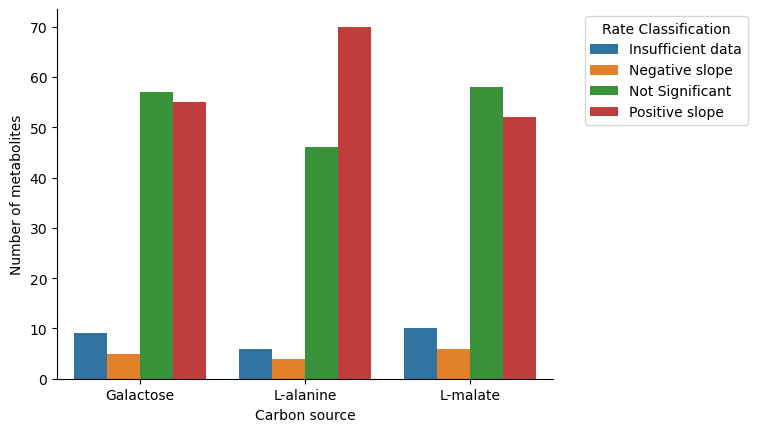

In [84]:
# Adjust p-values for multiple testing 
nanidx = df_rate['Slope'].notna()
for cs in df_rate['Carbon source'].unique():
    df_cs = df_rate.loc[(df_rate['Carbon source']==cs)&nanidx]
    adjusted_pvalues = smm.multipletests(df_cs['p-value'],alpha=0.05, method='fdr_bh')[1]
    df_rate.loc[(df_rate['Carbon source']==cs)&nanidx, 'adjusted p-value'] = adjusted_pvalues

# Define significance threshold
significance_threshold = 0.05

# Add a column to classify rates as positive, negative, or not significant
df_rate['Rate Classification'] = df_rate.apply(
    lambda row: 'Positive slope' if row['adjusted p-value'] < significance_threshold and row['Slope'] > 0 else
                'Negative slope' if row['adjusted p-value'] < significance_threshold and row['Slope'] < 0 else
                'Insufficient data' if np.isnan(row['Slope']) else
                'Not Significant',
    axis=1
)

# Group by Carbon source and Rate Classification, then count metabolites
rate_summary = df_rate.groupby(['Carbon source', 'Rate Classification'])['Metabolite'].count().reset_index()

# Rename columns for clarity
rate_summary.rename(columns={'Metabolite': 'Count'}, inplace=True)

# Display the summary
print(rate_summary)
sns.barplot(data = rate_summary, x = 'Carbon source', y = 'Count', hue = 'Rate Classification')
sns.despine()
plt.ylabel('Number of metabolites')
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1.05, 1), ncol = 1, title = 'Rate Classification')
plt.savefig(supp_figure_folder / 'ecoli_sintef_metabolite_rates_summary_fig_s10.pdf', bbox_inches='tight')
plt.savefig(supp_figure_folder / 'ecoli_sintef_metabolite_rates_summary_fig_s10.png', bbox_inches='tight')
print(rate_summary.loc[rate_summary['Rate Classification']!='Insufficient data'].groupby(['Carbon source'])['Count'].sum())


In [75]:
rate_summary.loc[rate_summary['Rate Classification']=='Positive', 'Count']/126*100

3     43.650794
7     55.555556
11    41.269841
Name: Count, dtype: float64

In [69]:
df_rate.loc[nanidx, 'Metabolite'].nunique()

126

In [79]:
abs_rate_idx = (df_rate['Rate [mmol/gDW/h]'].notna())&(df_rate['Rate [mmol/gDW/h]']> 0)
df_rate.loc[abs_rate_idx, 'Metabolite'].nunique()

34